## rocket equation

##### the delta-v concept is used here. 

#### The burnrate of fuel applied for x fraction of a second gives a specific impulse.   
#### When multiplied by the exhaust escape velocity this yields the specific thrust in newtons which in turn gives the applied force on the remaining rocket mass. 
#### The resulting diff equaltion thus depends on mass versus change in mass (impulse) at time t which gives the total accrued velocity

##### equations from https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-07-dynamics-fall-2009/lecture-notes/MIT16_07F09_Lec14.pdf

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#### defining constants

    m_0  = initial total rocket mass in kg  
    dmdt = change in mass (burnrate) in kg/s, negative as mass is expelled (depends on size and number of engines)
    t    = time in seconds  
    y    = altitude in meter
    y0   = initial altitude in meter 
    dydt = velocity in m/s  
    c    = exhaust velocity in m/s (determined by fuel type and nozzle shape)
    g    = gravitational acceleration = 9.8 m/s^2  
    n    = number of time samples  
    

burn time 90.0 seconds
burn rate 20 kg/s

altitude at end of burn [[194.72953989]] km
final velocity 7177.047825479159 m/s

coasting height in meter 2628.0620147558734 km
highest attained altitude in km [[2822.79155464]]


C:\Users\grav\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


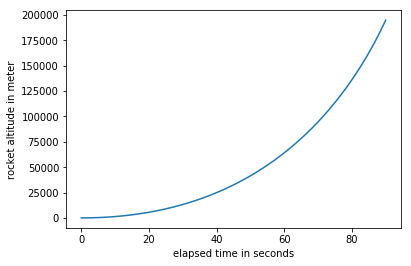

In [13]:
m_0 = 2000 #kg
dmdt = -20 #kg/s
c = 3500  #m/s
g = 9.8   #m/s^2
vehicle_mass_kg =200 #engines, payload, hull, guidance systems

# calculate the amount of fuel
fuel_kg = m_0 - vehicle_mass_kg

# calculate the length of the thrust. 
burn_time_seconds = fuel_kg/-dmdt


print ('burn time',burn_time_seconds,'seconds')
print ('burn rate', -dmdt, 'kg/s\n')


# defining the velocity at time t
def velocity(y, t, dmdt):    
    dydt =  -c * np.log ((m_0 + dmdt*t)/m_0) - g*t
    return dydt


# setting up timeline resolution for burning all fuel. 
samples_per_second = 10
n = burn_time_seconds * samples_per_second

t = np.linspace(0, burn_time_seconds, n)


#initial altitude in meter (launchpad)
y0= 10.0 

#solve ODE
y = odeint(velocity, y0, t, args = (dmdt,))

#velocity at end of burn, using last position of just calculated array
print('altitude at end of burn', y[int(n-1):]/1000, 'km' )


#getting the final velocity straight from the equation
v_at_end_of_burn = velocity (y, burn_time_seconds, dmdt)

print('final velocity', v_at_end_of_burn,  'm/s\n')


#max_altitude = altitude when fuel runs out + altitude attained during coasting 
# coasting altitude using basic kinetatics formula
# y_coast = v_final**2 - v_initial**2 / -2*a

y_coast = (0 - v_at_end_of_burn**2) / (-2*g)
print ('coasting height in meter',y_coast/1000, 'km')

max_altitude = y[int(n-1):] + y_coast
print ('highest attained altitude in km',max_altitude/1000)



plt.plot(t,y)
plt.xlabel ('elapsed time in seconds')
plt.ylabel ('rocket altitude in meter')
plt.show()


## optimizing

#### We're going to optimize for maximum altitude based of rate of fuel burn because engines are expensive as heck

#### we're using both drag and gravity this time

#### first the constants are defined
#### then the equations are written out for clarity, these are then combined for easier optimization
#### although drag is used, a constant air density is used without regard for altitude for simplicity, atmosphere extends forever

###### equations from https://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node103.html and http://www.rocketmime.com/rockets/qref.html


In [2]:
import numpy as np
from scipy.optimize import minimize

In [9]:
# defining drag coefficients
Cd = 0.006 #drag coefficient
A = 0.07 #area of rocket
rho = 0.8 # average air density
drag = 0.5*Cd*A*rho

# properties of our rocket
m_0 = 2000 #kg
dmdt = -30 #burn rate in kg/s
c = 3500  #exhaust velocity m/s
g = 9.8   #m/s^2
vehicle_mass_kg =200 #engines, payload, hull, guidance systems. 10% is average.


# calculate the amount of fuel
fuel_kg = m_0 - vehicle_mass_kg

#assuming constant burn rate we can get the 
average_mass = vehicle_mass_kg + 0.5*fuel_kg

# calculate the length of the thrust. 
burn_time_seconds = fuel_kg/-dmdt
t= burn_time_seconds
print('total thrust time',t,'s\n')



# the rocket equations governing velocity and height with drag and gravity assuming constant burnrate
def at_burnout (t):
    T = c*-dmdt #thrust
    k = (2* (np.sqrt((T-average_mass*g)*drag))/average_mass) #handy dandy constant
    q = (np.sqrt((T- vehicle_mass_kg *g)/drag)) #handy dandy constant
    v = (q * ((1-np.exp(-k*t))/(1+np.exp(-k*t)))) #velocity at time t
    y_T = (-average_mass/(2*drag))*np.log((T-average_mass*g-drag*v**2)/(T-average_mass*g)) #burn out altitude
    y_coast = (average_mass/(2*drag))*np.log((average_mass*g+drag*v**2)/(average_mass*g)) #coasting altitude gain
    max_altitude = y_T + y_coast
    return v, y_T, y_coast, max_altitude

#Double check these values against the single equation below
print ('final velocity',at_burnout(t)[0]/1000,'km/s\n','burn out height',at_burnout(t)[1]/1000, 'km\n', 
       'coast height',at_burnout(t)[2]/1000, 'km\n','max height',at_burnout(t)[3]/1000, 'km\n')



#now combined into a single equation as a function of burnrate. Added a negative for the minimization step later 
def maximum_height(dmdt):    
    y = -(((average_mass/(2*drag))*np.log((average_mass*g+drag*((np.sqrt(((c*-dmdt)- vehicle_mass_kg *g)/drag)) *
                ((1-np.exp(-(2* (np.sqrt(((c*-dmdt)-average_mass*g)*drag))/average_mass)*(fuel_kg/-dmdt)))/
                 (1+np.exp(-(2* (np.sqrt(((c*-dmdt)-average_mass*g)*drag))/average_mass)*(fuel_kg/-dmdt)))))**2)/
                    (average_mass*g)))+(-average_mass/(2*drag))*np.log(((c*-dmdt)-average_mass*g-drag*
                        ((np.sqrt(((c*-dmdt)- vehicle_mass_kg *g)/drag)) * ((1-np.exp(-(2* (np.sqrt(((c*-dmdt)-average_mass*g)*
                            drag))/average_mass)*(fuel_kg/-dmdt)))/(1+np.exp(-(2* (np.sqrt(((c*-dmdt)-average_mass*g)*drag))/
                                average_mass)*(fuel_kg/-dmdt)))))**2)/((c*-dmdt)-average_mass*g)))
    return y

print('from single equation',-maximum_height(-30)/1000, 'km')



total thrust time 60.0 s

final velocity 5.291628690860636 km/s
 burn out height 167.67665683946214 km
 coast height 1185.5418375303661 km
 max height 1353.2184943698285 km

from single equation 1353.2184943698285 km


In [4]:
# must be able to lift off, lets have minimum thrust be at least 3 x weight
def constraint1(dmdt):
    return (c*-dmdt) - 3*(m_0*g)

con1 = {'type':'ineq','fun':constraint1}
cons = [con1]


# we cannot fit more than 10 engines, need at least 1
bounds = [(-50.0, -5.0)]


# lets set initial guess at 30 kg/s, negative as the mass is leaving the rocket
x0 = [-30]
sol = minimize(maximum_height, x0, method = 'SLSQP', bounds = bounds, constraints = cons)
print (sol)

     fun: -1358494.4773317748
     jac: array([-976.40625])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([-16.8])


### and there we have it, optimum burn rate is 16.8 kg/s so we should use about 3 engines